### Speech Commands audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split

from model import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
# download datasets from torchaudio

train_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='training')
test_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='testing')
val_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='validation')


In [9]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print( f'nr of observations in validation set : {len(val_dataset)}')
print(f'total length : {len(train_dataset)+len(test_dataset)+len(val_dataset)}')

nr of observations in train set : 84843
nr of observations in test set : 11005
nr of observations in validation set : 9981
total length : 105829


In [10]:
# to encode labels

labels = [sample[2] for sample in tqdm(val_dataset)]
labels = set(labels)
labels = list(labels)
print(f'{len(labels)} mots au total : {labels}')

100%|██████████| 9981/9981 [01:30<00:00, 109.96it/s]

35 mots au total : ['right', 'house', 'four', 'down', 'off', 'backward', 'learn', 'marvin', 'dog', 'six', 'zero', 'eight', 'go', 'one', 'bird', 'visual', 'stop', 'two', 'five', 'wow', 'no', 'left', 'tree', 'bed', 'forward', 'follow', 'nine', 'cat', 'sheila', 'three', 'yes', 'on', 'seven', 'happy', 'up']


In [11]:
# Create a class for the Dataset (subclass of Dataset) and only keep the 3 valuable features
# Apply necessary transformations to the data

class ModifiedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transformation, target_sample_rate, nr_samples, labels):
        self.original_dataset = original_dataset
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        self.labels = labels
        self.encoder = LabelEncoder()
        
        self.encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        
        og_waveform, og_sample_rate, og_label, speaker_id, utterance = self.original_dataset[idx]
        
#         waveform = og_waveform.to(self.device)
        waveform = self._resample(og_waveform, og_sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
        spectrogram = self.transformation(waveform)
        
        encoded_label = self.encoder.transform([og_label])
        encoded_label = encoded_label.squeeze().astype(np.int64)

        return waveform, og_sample_rate, encoded_label, spectrogram
    
    def _resample(self, wvf, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf
    
    def _trim(self, wvf):
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf
        
    def _zero_pad(self, wvf):
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf

In [12]:
# create the updated datasets
fixed_sample_rate = 16000 #16000
num_samples = 16000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 128 #64
n_mfcc = 40


mel_spectro = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk",
)


transfo_mfcc = torchaudio.transforms.MFCC(
    sample_rate=fixed_sample_rate,
    n_mfcc=n_mfcc,
    dct_type=2, 
    norm='ortho', 
    log_mels=False)

spectro = torchaudio.transforms.Spectrogram(n_fft=n_fft,
                                            hop_length = hop_length,
                                            power=2.0,
                                            normalized=False,
                                            center=True,
                                            pad_mode='reflect',
                                            onesided=True,
                                            return_complex=None)


def modify_data(original_dataset):
    return ModifiedDataset(original_dataset, mel_spectro, fixed_sample_rate, num_samples, labels)

modif_train = modify_data(train_dataset)
modif_test = modify_data(test_dataset)
modif_val = modify_data(val_dataset)

c:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [13]:
# unload original datasets to free up memory

del train_dataset, test_dataset, val_dataset

In [14]:
modif_train

11005it [03:12, 57.13it/s]


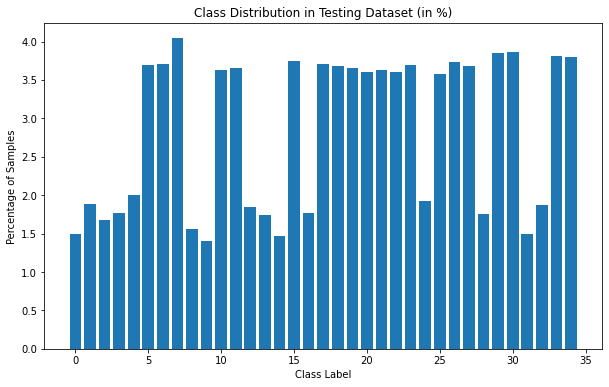

84843it [22:29, 62.87it/s]


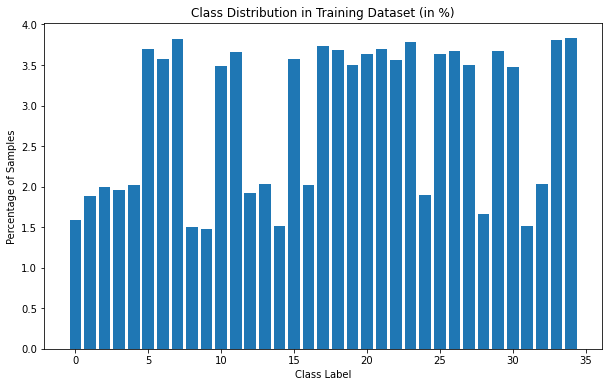

9981it [03:06, 53.57it/s]


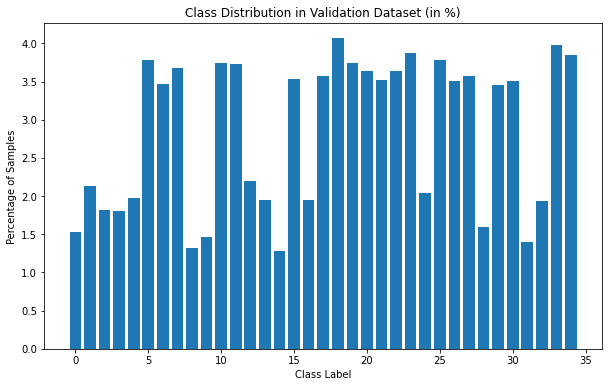

In [15]:
# Check if the dataset is balanced over all the classes

class_distribution_percent_test, class_weights_test = class_distrib(modif_test, 'Testing Dataset')
class_distribution_percent_train, class_weights_train = class_distrib(modif_train, 'Training Dataset')
class_distribution_percent_val, class_weights_val = class_distrib(modif_val, 'Validation Dataset')

In [16]:
# Convert the class_weights dictionary to a tensor (for the loss)

## TRANSFORMER EN FONCTION

weights_list_test = [class_weights_test[i] for i in range(len(class_weights_test))]
weights_list_train = [class_weights_train[i] for i in range(len(class_weights_train))]
weights_list_val = [class_weights_val[i] for i in range(len(class_weights_val))]

class_weights_test_tensor = torch.tensor(weights_list_test, dtype=torch.float).to(device)
class_weights_train_tensor = torch.tensor(weights_list_train, dtype=torch.float).to(device)
class_weights_val_tensor = torch.tensor(weights_list_val, dtype=torch.float).to(device)



Dataset modif_train - Number of Samples: 84843
Dataset modif_test - Number of Samples: 11005
Dataset modif_val - Number of Samples: 9981


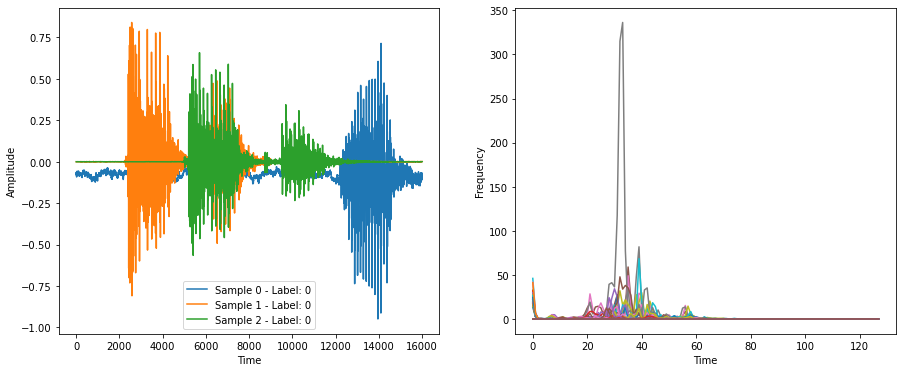

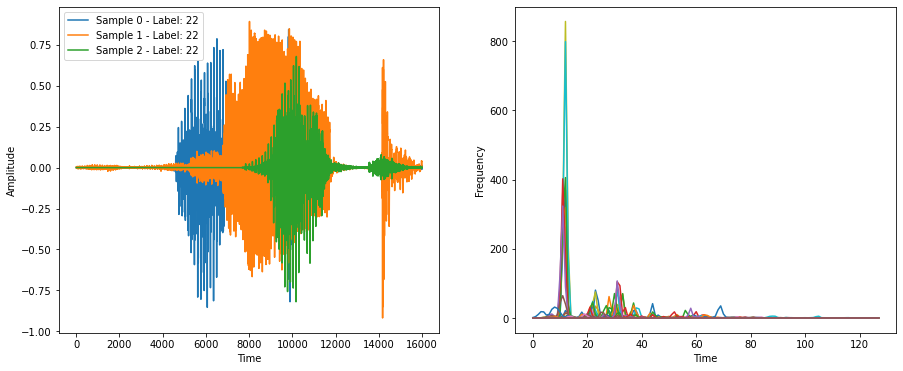

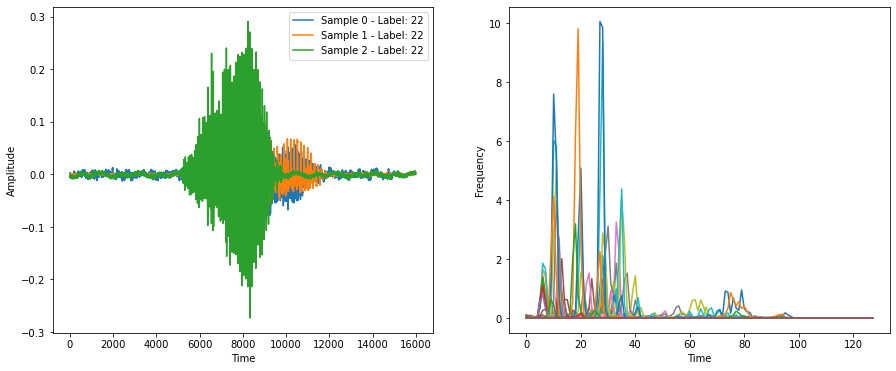

In [17]:
# see what's inside (plot waveforms and mel_spectrograms)
number_of_samples = 3
dataset_names = ["modif_train", "modif_test", "modif_val"]
datasets = [modif_train, modif_test, modif_val]


for dataset, dataset_name in zip(datasets, dataset_names):
    
    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")
    plt.title(f"Dataset {dataset_name}")
    
    plt.clf()
    
    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, spectrogram = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, spectrogram = dataset[i]
        ax.plot(spectrogram.squeeze(), label=f"Sample {i} - Label: {label}")
#        ax.legend()
        
    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

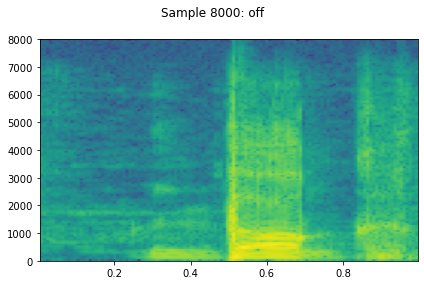

In [18]:
i = 8000
waveform, sample_rate, label, _ = modif_train[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {labels[label]}")
IPython.display.Audio(waveform, rate=sample_rate)


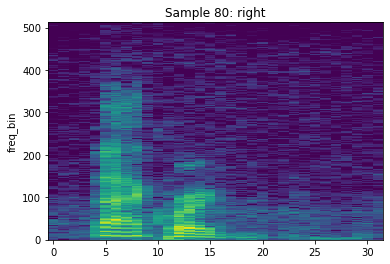

In [19]:
i = 80
waveform, sample_rate, label, _ = modif_train[i]
plot_spectrogram(torchaudio.transforms.Spectrogram(n_fft=1024)(waveform).squeeze(), title=f"Sample {i}: {labels[label]}")
IPython.display.Audio(waveform, rate=sample_rate)


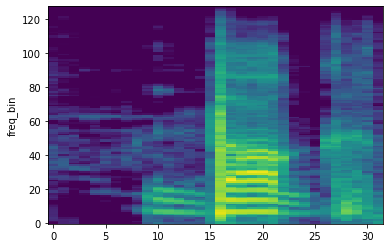

In [20]:
i = 8000
waveform, sample_rate, label, spectrogram = modif_train[i]
plot_spectrogram(spectrogram[0]) #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


In [ ]:
# #check that they all have the same sample rate and number of samples (in validation subset)

# samplerate_val = []
# waveforms_val = []

# for i in tqdm(range(len(modif_val))):
#     waveform, sr , _ , _ = modif_val[i]
#     waveforms_val.append(waveform.shape[1])
#     samplerate_val.append(sr)


# print(f'Same number of samples : {all(wf == waveforms_val[0] for wf in waveforms_val)}')    
# print(f'Same sample rate : {all(sr == samplerate_val[0] for sr in samplerate_val)}')    


In [21]:
# load the data into DataLoaders
batch_size = 64
train_dataloader = DataLoader(modif_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(modif_test, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(modif_val, batch_size=batch_size, shuffle=False)

In [ ]:
# Build the model 


In [22]:
cnn = CNN()
# cnn = CNN_mfcc()
# cnn = CNN_spectro()

cnn.to(device)

train_criterion = nn.CrossEntropyLoss(weight=class_weights_train_tensor)
test_criterion = nn.CrossEntropyLoss(weight=class_weights_test_tensor)
val_criterion = nn.CrossEntropyLoss(weight=class_weights_val_tensor)

optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)


In [23]:
# Model summary
input_size = modif_train[0][3].shape
summary(cnn, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 126, 30]              80
              ReLU-2           [-1, 8, 126, 30]               0
         MaxPool2d-3            [-1, 8, 63, 15]               0
            Conv2d-4           [-1, 16, 59, 11]           3,216
              ReLU-5           [-1, 16, 59, 11]               0
         MaxPool2d-6            [-1, 16, 29, 5]               0
            Conv2d-7            [-1, 32, 27, 3]           4,640
              ReLU-8            [-1, 32, 27, 3]               0
         MaxPool2d-9            [-1, 32, 13, 1]               0
          Flatten-10                  [-1, 416]               0
           Linear-11                  [-1, 128]          53,376
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 35]           2,275
          Softmax-14                   

In [24]:
# try with a random tensor of the right dimensions
cnn(torch.rand([64,1,128,32]).to(device))[0]
# cnn(torch.rand([64,1,40,81]).to(device))[0] # MFCC
# cnn(torch.rand([64,1,513,32]).to(device))[0] # spectrogram

tensor([ 0.1020, -0.0222,  0.1207, -0.0301, -0.0375,  0.0753, -0.0846,  0.1227,
         0.0859,  0.0814,  0.0847, -0.0590, -0.0297, -0.0028,  0.0110, -0.0053,
         0.0802, -0.0036, -0.0795,  0.0536,  0.1061,  0.1067,  0.0267,  0.0493,
         0.0386, -0.0982,  0.0590, -0.0923, -0.0207, -0.0220, -0.0990,  0.0589,
        -0.0500, -0.0814,  0.0868], grad_fn=<SelectBackward0>)

In [25]:
n_epochs = 10
saving_path = 'mels_10eps.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(cnn, train_dataloader, val_dataloader, optimizer, train_criterion, val_criterion, device, n_epochs, saving_path)

Train Epoch: 0 [0/84843 (0%)]	Loss: 3.538620
Train Epoch: 0 [6400/84843 (8%)]	Loss: 3.364963
Train Epoch: 0 [12800/84843 (15%)]	Loss: 3.202270
Train Epoch: 0 [19200/84843 (23%)]	Loss: 3.047983
Train Epoch: 0 [25600/84843 (30%)]	Loss: 3.014144
Train Epoch: 0 [32000/84843 (38%)]	Loss: 2.745765
Train Epoch: 0 [38400/84843 (45%)]	Loss: 2.362919
Train Epoch: 0 [44800/84843 (53%)]	Loss: 2.237468
Train Epoch: 0 [51200/84843 (60%)]	Loss: 2.786120
Train Epoch: 0 [57600/84843 (68%)]	Loss: 2.171016
Train Epoch: 0 [64000/84843 (75%)]	Loss: 1.975894
Train Epoch: 0 [70400/84843 (83%)]	Loss: 2.294253
Train Epoch: 0 [76800/84843 (90%)]	Loss: 2.007053
Train Epoch: 0 [83200/84843 (98%)]	Loss: 1.864139
epoch n.0 : Average Loss = 2.632855920590247, Accuracy = 23.70%
epoch n.0 : Val Average Loss = 2.041215105698659, Val Accuracy = 38.55%
Train Epoch: 1 [0/84843 (0%)]	Loss: 1.896422
Train Epoch: 1 [6400/84843 (8%)]	Loss: 2.145049
Train Epoch: 1 [12800/84843 (15%)]	Loss: 1.926616
Train Epoch: 1 [19200/84843 

RuntimeError: Failed to open the input "SpeechCommands\speech_commands_v0.02\backward\02ade946_nohash_4.wav" (No such file or directory).

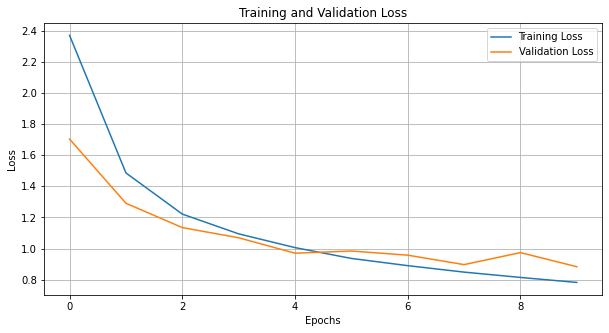

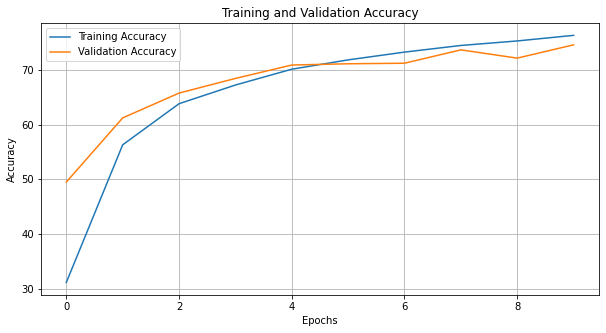

In [ ]:
# plot learning curves

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.savefig('losses.png')
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.savefig('accuracies.png')
plt.show()


In [ ]:
# Evaluation on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
output = test_dataloader.dataset[i][3].unsqueeze(1).to(device)
pred = cnn(output)
target = test_dataloader.dataset[i][2].astype(np.int64)
print(pred.argmax(dim=1, keepdim=False))
print(target)

tensor([26])
28


In [ ]:
test_loss, test_accuracy = test_model(cnn, test_dataloader, test_criterion, device)


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [01:00<00:00,  2.87it/s]


Test set: Average loss: 0.0155, Accuracy: 7926/11005 (72.0%)



In [ ]:
# Save the model

# torch.save(cnn.state_dict(), "cnn_10ep_24-10.pth")

In [ ]:
# After training, to load the best model for inference or evaluation
best_model = CNN()
# best_model = CNN_mfcc()

state_dict = torch.load(saving_path, map_location=device)
best_model.load_state_dict(state_dict)


In [ ]:
# def predict(model, input_data, target, labels):
#     model.eval()
#     with torch.no_grad():
#         output = model(input_data.unsqueeze(dim=0))
#         pred = output.argmax(dim=1, keepdim=True)
#         predicted_label = labels[pred]
#         expected_label = labels[target]
#     return predicted_label, expected_label



In [ ]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(cnn, input_data, target, labels)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : six, Expected label : six


In [ ]:
# Inference

random_index = random.randint(0, len(test_dataloader) - 1)
print(random_index)

for i, (wvf, sr, label, mels) in tqdm(enumerate(test_dataloader)):
    if i == random_index : # random_index:
        break

cnn.eval()
with torch.no_grad():
    mels = mels.to(device)
    preds = cnn(mels)

print(f"Predicted: '{preds.argmax(dim=1, keepdim=False)}',\nExpected: '{label}'")

100


100it [00:25,  3.85it/s]

Predicted: 'tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 10, 29, 23, 23, 23, 26, 23, 23, 23,
        23, 23, 23, 23, 10, 23, 23, 23, 23, 23, 23, 23, 23, 26, 23, 23, 23, 23,
        23, 23, 23, 26, 23, 23, 26, 23, 23, 23, 23, 23, 23, 10, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23])',
Expected: 'tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23])'


- Est-ce que le rééchantillonnage est nécessaire si tous les audios ont déjà la même fréquence d'échantillonnage ?
- Quand faut-il faire de la segmentation ?
- S'il y a plusieurs channels, est-ce que prendre la moyenne fonctionne toujours, ou il y a un risque de déteriorer le signal ?
- Si nombre de samples =/= (taille d'échant =/=) : trim ou pad, mais on peut aussi stretch ?
- Quand faut-il mieux utiliser une transformation en MelSpectrograms ou en mfcc ?
- Rajouter nn.Dropout() après chaque couche ?
- scheduler ?
- tester mfcc ?
- with dropout : 58,8% test accuracy